# Modeling Revenue using ARIMA

In [59]:
import pandas as pd
import numpy as np
import sys
sys.path.append("../..")
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy.stats import norm
from statsmodels.distributions.empirical_distribution import ECDF
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.linear_model import Ridge
from statsmodels.tsa.arima_model import ARIMA

from data.scripts.simplified_finance_stats.fin_stats import fin_stats
from data.scripts.simplified_finance_stats.fin_ratios import get_ratios
from data.scripts.simplified_finance_stats.fin_stats_2 import fin_stats_2
from data.scripts.simplified_finance_stats.stock_stats import stock_stats

pd.options.display.max_rows = 999

### Initialize the data 

In [2]:
# Set path for data
base_path = '../../data/'
sheets_path = 'combined_simplified/combined_all_us.csv' 
other_path = 'combined_simplified/others_all_us.csv'
mkt_path = 'combined_simplified/stock_stats_all_us.csv'

equity_list_path = '../../equity_list/all_us_list.csv'

In [3]:
# setup all data
finances = fin_stats(base_path + sheets_path)
fin_others = fin_stats_2(base_path + other_path)
mkt_data = stock_stats(base_path + mkt_path)

Total Missing tickers: 181
Total Missing tickers: 181
Total Missing tickers: 181


In [4]:
equity_list = pd.read_csv(equity_list_path)['tick'].tolist()

### Data Preprocessing

For now, only considering companies with more than 30 year history

In [5]:
# Methods for data processing

def get_processed_sheet(tick):
    """Returns processed income sheet with no 0.0 revenue fields"""
    df = finances.get_sheet(tick,"income_sheet")
    revt = df.loc['revt']
    ix = revt[(revt!=0.0)].index.tolist()
    df = df[ix]
    return df

def get_time_hist(tick):
    """Returns the number of years the company has been listed on stock exchange"""
    df = get_processed_sheet(tick)
    return df.shape[1]


In [6]:
# Create a list of equities with 30 year or more of historical data

equity_list_30_yr = []

for i,tick in enumerate(equity_list):
    try:
        if get_time_hist(tick) > 30:
            equity_list_30_yr.append(tick)
    
    except:
        pass
        
print("Number of companies with atleast 30 year history: %i"%len(equity_list_30_yr))

AFP not found in income_sheet
CWTR not found in income_sheet
CTYN not found in income_sheet
CWE not found in income_sheet
CNF not found in income_sheet
CTC not found in income_sheet
DOW not found in income_sheet
DOYL not found in income_sheet
EK not found in income_sheet
HB not found in income_sheet
ICX not found in income_sheet
KLU not found in income_sheet
KES not found in income_sheet
KRN not found in income_sheet
MOB not found in income_sheet
MMED not found in income_sheet
NAS not found in income_sheet
GAS not found in income_sheet
OMAH not found in income_sheet
OVT not found in income_sheet
PICN not found in income_sheet
PINK not found in income_sheet
PITS not found in income_sheet
RJR not found in income_sheet
RLM not found in income_sheet
SAFC not found in income_sheet
SPC not found in income_sheet
SY not found in income_sheet
SNS not found in income_sheet
VSTA not found in income_sheet
WPO not found in income_sheet
WSC not found in income_sheet
Z not found in income_sheet
ACD n

In [114]:
def get_train_test_split(x,y,train_period=25):
    """Splits the train and test data in order with the train_size as the splitting point """
    
    x_train = x[0:train_size]
    x_train = x_train.reshape((len(x_train),1))

    x_test = x[train_size-1::]
    x_test = x_test.reshape((len(x_test),1))
    
    y_train = df.values[0:train_size]
    y_train = y_train.reshape((len(y_train),1))

    y_test = df.values[train_size-1::]
    y_test = y_test.reshape((len(y_test),1))
    
    return x_train,y_train,x_test,y_test

def ridge_result(x_train,y_train,x_test,y_test):
    """Returns the R-squared, MSE for the prediction using ridge regression"""
    clf = Ridge(alpha=1.0)
    clf.fit(x_train,y_train)
    y_pred = clf.predict(x_test)
    r2 = r2_score(y_pred,y_test)
    mse = mean_squared_error(y_pred,y_test)
    
    return r2,mse
    
def arima_result(df,y_test,train_period = 25):   
    p_range = np.arange(5,10)
    d_range = np.arange(2,4)
    q_range = np.arange(2,5)
    
    ix = pd.to_datetime(df.index,format="%Y")
    df = pd.Series(data=df.values,index=ix)
    
    x_test_start = df.index[train_period]
    x_test_end = df.index[-1]
    
    
    
    for p in p_range:
        for d in d_range:
            for q in q_range:
                model = ARIMA(df.iloc[0:train_period],order=(p,d,q))
                model.fit(disp=0)
                y_pred = model.predict(start=x_test_start,end=x_test_end)
                
                r2_tmp = r2_score(y_pred,y_test)
                mse_tmp = mean_squared_error(y_pred,y_test)
                
                if mse_tmp < mse:
                    mse = mse_tmp
                    r2 = r2_tmp

    return r2,mse
                
                
    

In [115]:

n = 30
x = np.arange(n)

for i,tick in enumerate(equity_list_30_yr):
        #try:
        df = get_processed_sheet(tick).loc['revt'].iloc[-1*n:]
        x_train,y_train,x_test,y_test = get_train_test_split(x,df.values)

        # Linear regression - Ridge
        r2,mse = ridge_result(x_train,y_train,x_test,y_test)

        # ARIMA
        r2_a,mse_a = arima_result(df,y_test)

        print r2_a,mse_a

            
#        except ValueError as e:
#            raise e
#            print(i,tick)
            
        if i == 0:    
            break

ValueError: The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.

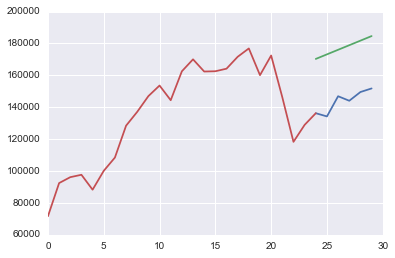

In [57]:
plt.plot(x_test,y_test,x_test,y_pred)
plt.plot(x_train,y_train);

In [85]:
a=pd.to_datetime(df.index,format="%Y")

In [102]:
d= df.values

In [103]:
pd.Series(data=d,index=a)

1987-01-01     4387.876
1988-01-01     4936.991
1989-01-01     5379.751
1990-01-01     6158.682
1991-01-01     6876.588
1992-01-01     7851.912
1993-01-01     8407.843
1994-01-01     9156.009
1995-01-01    10012.194
1996-01-01    11013.460
1997-01-01    11883.462
1998-01-01    12477.845
1999-01-01    13177.625
2000-01-01    13745.916
2001-01-01    16285.246
2002-01-01    17684.663
2003-01-01    19680.561
2004-01-01    19680.016
2005-01-01    22287.808
2006-01-01    22476.322
2007-01-01    25914.238
2008-01-01    29527.552
2009-01-01    30764.707
2010-01-01    35166.721
2011-01-01    38851.259
2012-01-01    39873.910
2013-01-01    21848.000
2014-01-01    20247.000
2015-01-01    20405.000
2016-01-01    20853.000
dtype: float64